In [3]:
import sys, getopt, datetime, codecs
if sys.version_info[0] < 3:
    import got
else:
    import got3 as got

In [4]:
from pymongo import MongoClient

## Create MongoDB

In [5]:
client = MongoClient('localhost', 27017)
db = client['twitter_db']
collection = db['twitter_collection']

In [7]:
tweetCriteria = got.manager.TweetCriteria().setQuerySearch('ChennaiFloods').setSince("2015-12-01").setUntil("2015-12-02").setMaxTweets(6000)

## Get Tweets

In [11]:
def streamTweets(tweets):
    for t in tweets:
        obj = {"user": t.username, "retweets": t.retweets, "favorites": 
               t.favorites, "text":t.text,"geo": t.geo,"mentions": 
               t.mentions, "hashtags": t.hashtags,"id": t.id, "permalink": t.permalink,}
        tweetind = collection.insert_one(obj).inserted_id
        
got.manager.TweetManager.getTweets(tweetCriteria, streamTweets)

 ...]

## Display Tweets

In [14]:
import pandas as pd

client = MongoClient ('localhost', 27017)
db = client ['twitter_db']
collection = db ['twitter_collection']
df_tweets = pd.DataFrame(list(collection.find()))

In [36]:
df_tweets.head()

,_id,favorites,geo,hashtags,id,mentions,permalink,retweets,text,user
0,5d33ed3a180dc1ee684cc3bb,0,,#ChennaiFloods,671841135778598914,,https://twitter.com/deeepakkher/status/6718411...,0,#ChennaiFloods havoc caused by incessant rains...,
1,5d33ed3b180dc1ee684cc3bc,0,,#ChennaiFloods #chennairainshelp #chennairains,671841120574312448,,https://twitter.com/sreeni94/status/6718411205...,9,Blankets....Bread.. Biscuits PL Share #Chennai...,
2,5d33ed3b180dc1ee684cc3bd,0,,#ChennaiFloods #chennairainshelp #chennairains,671840754554159104,,https://twitter.com/sreeni94/status/6718407545...,3,PLease Share #ChennaiFloods #chennairainshelp ...,
3,5d33ed3b180dc1ee684cc3be,0,,#chennairains #chennai #chennaifloods,671840657611198465,,https://twitter.com/oscar_suites/status/671840...,0,#chennairains #chennai #chennaifloods,
4,5d33ed3b180dc1ee684cc3bf,2,,#ChennaiFloods #chennairains #feelinguseless #...,671840615685074945,,https://twitter.com/purniMAdhu/status/67184061...,0,What's happening to chennai? Please everyone b...,


In [18]:
df_tweets[['text', 'hashtags', 'retweets']].head()

,text,hashtags,retweets
0,#ChennaiFloods havoc caused by incessant rains...,#ChennaiFloods,0
1,Blankets....Bread.. Biscuits PL Share #Chennai...,#ChennaiFloods #chennairainshelp #chennairains,9
2,PLease Share #ChennaiFloods #chennairainshelp ...,#ChennaiFloods #chennairainshelp #chennairains,3
3,#chennairains #chennai #chennaifloods,#chennairains #chennai #chennaifloods,0
4,What's happening to chennai? Please everyone b...,#ChennaiFloods #chennairains #feelinguseless #...,0


## Tweets Exploration

In [24]:
import nltk
from nltk.corpus import brown
from nltk import FreqDist

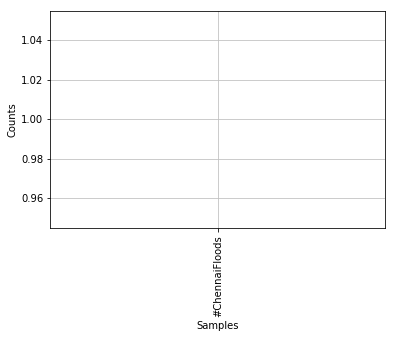

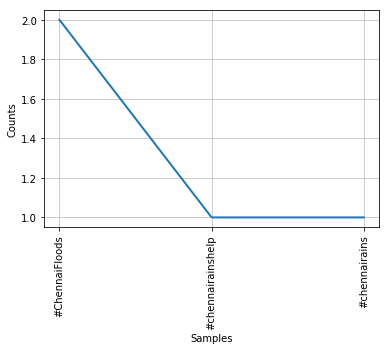

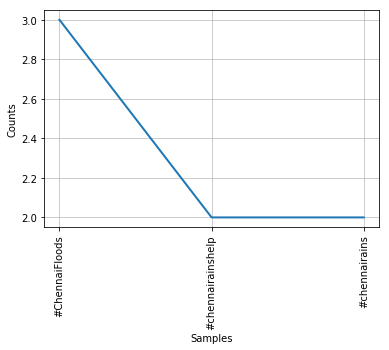

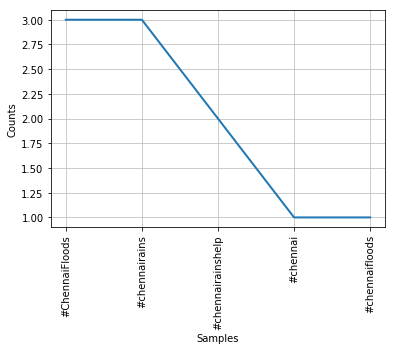

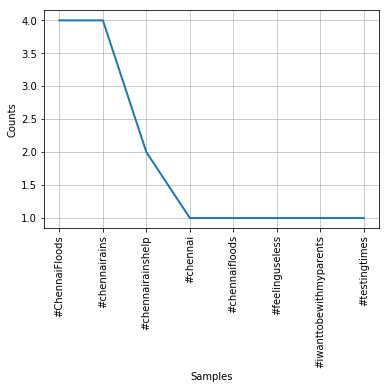

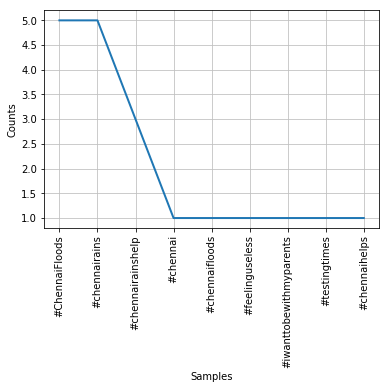

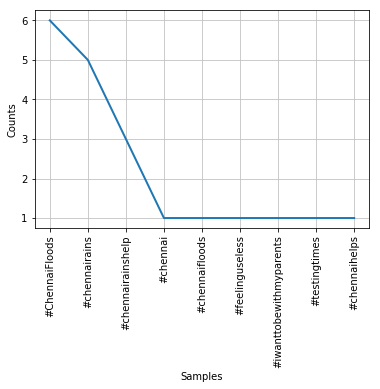

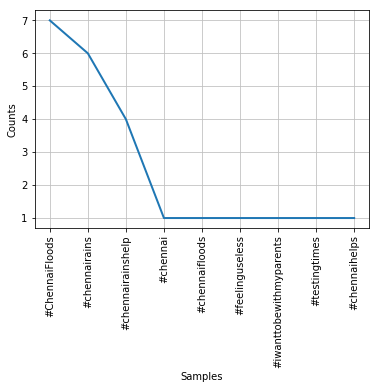

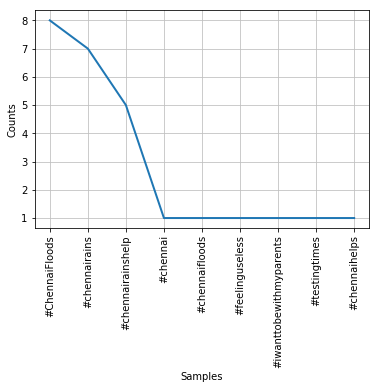

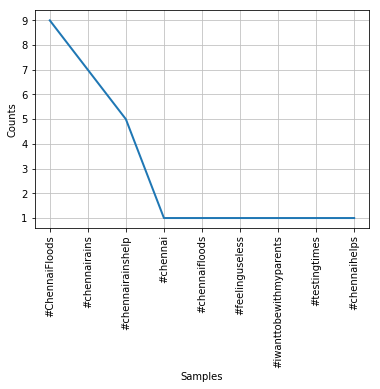

In [43]:
hashtags = []
for hs in df_tweets["hashtags"][:10]: # Each entry may contain multiple hashtags. Split.
    hashtags += hs.split(" ")
    fdist1 = FreqDist(hashtags)
    fdist1.plot(10)

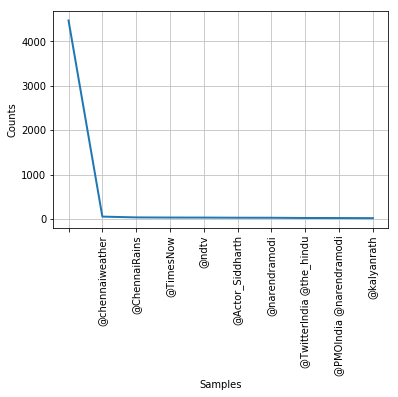

In [46]:
mentions = df_tweets["mentions"].tolist()
fdist2 = FreqDist(mentions)
fdist2.plot(10)

In [64]:
from nltk.collocations import *

In [65]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(words, 5)
finder.apply_freq_filter(5)
print(finder.nbest(bigram_measures.likelihood_ratio, 10))

[('pic', 'twitter'), ('song', 'dedication'), ('dedication', 'cause'), ('song', 'support'), ('dedication', 'support'), ('support', 'cause'), ('national', 'media'), ('pani', 'pani'), ('lady', 'labour'), ('song', 'share')]


## Tweets Processing

In [47]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re, string

In [51]:
tweets_texts = df["text"].tolist()

stopwords = stopwords.words('english')
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

In [54]:
def process_tweet_text(tweet):
    if tweet.startswith('@null'):
        return "[Tweet not available]"
    
    tweet = re.sub(r'\$\w*','',tweet)
    tweet = re.sub(r'https?:\/\/.*\/\w*','',tweet)
    tweet = re.sub(r'['+string.punctuation+']+', ' ',tweet)
    twtok = TweetTokenizer(strip_handles=True, reduce_len=True)
    tokens = twtok.tokenize(tweet)
    tokens = [i.lower() for i in tokens if i not in stopwords and len(i) > 2 and i in english_vocab]
    
    return tokens

In [55]:
words = []
for tw in tweets_texts:
    words += process_tweet_text(tw)

In [63]:
words[:8]

['havoc', 'incessant', 'flooding', 'result', 'cause', 'misery', 'city', 'pic']

## Tweets Clustering

In [70]:
cleaned_tweets = [] 
for tw in tweets_texts:
    words = process_tweet_text(tw)
    cleaned_tweet = " ".join(w for w in words if len(w) > 2 and  w.isalpha())     
    cleaned_tweets.append(cleaned_tweet)

df['CleanTweetText'] = cleaned_tweets

In [72]:
df[['CleanTweetText']].head()

,CleanTweetText
0,havoc incessant flooding result cause misery city
1,pic twitter
2,
3,
4,happening everyone safe


In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3))  
tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_tweets)  
feature_names = tfidf_vectorizer.get_feature_names()

In [76]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(tfidf_matrix)  
print(dist)

[[ 0.00000000e+00  1.00000000e+00  1.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00 -2.22044605e-16  1.00000000e+00 ... -2.22044605e-16
   1.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 ...
 [ 1.00000000e+00 -2.22044605e-16  1.00000000e+00 ... -2.22044605e-16
   1.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  1.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  0.00000000e+00]]


In [78]:
from sklearn.cluster import KMeans

num_clusters = 3  
km = KMeans(n_clusters=num_clusters)  
km.fit(tfidf_matrix)  
clusters = km.labels_.tolist()  
df['ClusterID'] = clusters  
print(df['ClusterID'].value_counts())

2    5068
1     407
0     404
Name: ClusterID, dtype: int64


In [80]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(num_clusters):
    print("Cluster {} : Words :".format(i))
    for ind in order_centroids[i, :10]:
        print(' %s' % feature_names[ind])

Cluster 0 : Words :
 help
 open
 people
 safe
 hindu
 number
 share
 stuck
 open people
 people stuck
Cluster 1 : Words :
 twitter
 pic twitter
 pic
 hall accommodate
 half city important
 half early
 half water
 half water shaking
 half yearly
 half yearly week
Cluster 2 : Words :
 twitter
 pic
 pic twitter
 rain
 people
 help
 safe
 media
 please
 news


<hr/>